In [27]:
"""
观察sensor arrangement对FMG信号的影响，用label.txt的时间戳划分出包含5个完整收缩-舒张过程的信号，方便进行信号相似性分析
"""
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import time
import sys
sys.path.append("..")
from utils.utils_iFEMG_feature import read_label


folder_path = r"D:\LEARNINNNNNNNNNNNNG\ExperimentData\20250319major_revision\传感器位置对FMG的影响"
file_name_lst = ['cen-1kg', 'cen-2kg', 'nei-1kg', 'nei-2kg', 'wai-1kg', 'wai-2kg', 'jin-1kg', 'jin-2kg', 'yuan-1kg', 'yuan-2kg']


# 函数定义
def str_to_milliseconds(time_str, format_str="%Y-%m-%d %H:%M:%S,%f", timezone="UTC"):
    """
    将时间字符串转换为毫秒级时间戳
    
    参数:
        time_str: 时间字符串
        format_str: 时间格式
        timezone: 时区名称（如 'Asia/Shanghai'）
    """
    # 解析时间字符串
    dt = datetime.strptime(time_str, format_str)
    
    # 如果指定了时区，将时间转换到该时区
    if timezone:
        tz = pytz.timezone(timezone)
        dt = tz.localize(dt)
    
    # 转换为毫秒级时间戳
    return int(dt.timestamp() * 1000)

# 使用示例
time_str = "2025-03-21 14:53:24,245"

# 默认使用本地时区
local_timestamp = str_to_milliseconds(time_str)
print(f"本地时间戳: {local_timestamp}")

# 指定上海时区
shanghai_timestamp = str_to_milliseconds(time_str, timezone='Asia/Shanghai')
print(f"上海时区时间戳: {shanghai_timestamp}")

# 使用UTC时区
utc_timestamp = str_to_milliseconds(time_str, timezone='UTC')
print(f"UTC时间戳: {utc_timestamp}")

本地时间戳: 1742568804245
上海时区时间戳: 1742540004245
UTC时间戳: 1742568804245


In [ ]:
# 处理所有文件的时间戳
filtered_signal_lst = []
for file_name in file_name_lst:
    # 文件读取
    raw_data = pd.read_table(folder_path + "\\" + file_name + ".db", sep = ';', header = None)
    label = read_label(folder_path + "\\" + file_name + ".txt")

    # 处理label中的时间戳获得信号的开始时间和结束时间
    start_t = label[0][0] + " " + label[0][1]
    start_t_stamp = str_to_milliseconds(start_t, format_str="%Y-%m-%d %H:%M:%S.%f", timezone='UTC')

    end_t = label[10][0] + " " + label[10][1]
    end_t_stamp = str_to_milliseconds(end_t, format_str="%Y-%m-%d %H:%M:%S.%f", timezone='UTC')

    # 原始信号数据中的时间字符串转换为ms精度时间戳
    raw_data['timestamp'] = pd.to_datetime(raw_data[0], format="%Y-%m-%d %H:%M:%S,%f").astype('int64') // 10**6
    
    # 根据时间戳筛选数据，channel 1是FMG信号数据，将series重命名为file_name保存在lst中，方便之后进行合并
    filtered_signal_lst.append(raw_data[(raw_data['timestamp'] >= start_t_stamp) & (raw_data['timestamp'] <= end_t_stamp)][1].rename(file_name))


In [29]:
# 选取series的前112000个点，去除series原来的index，合并为df
final_df = pd.concat([s.head(112000).reset_index(drop=True) for s in filtered_signal_lst], axis=1, ignore_index=True)
final_df.columns = file_name_lst

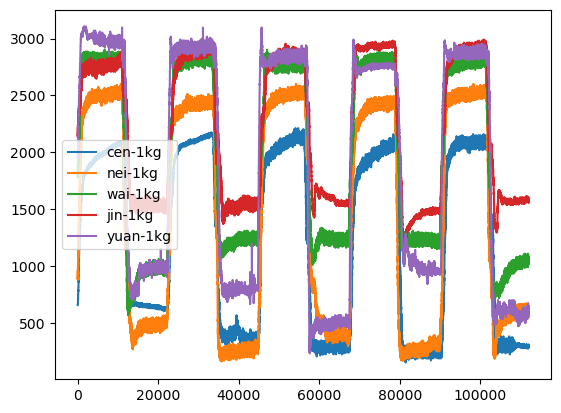

nei-1kg     0.969708
wai-1kg     0.949001
jin-1kg     0.973719
yuan-1kg    0.951592
Name: cen-1kg, dtype: float64


In [32]:
# 选择1kg组，计算各列数据的相关系数
columns_of_interest = ['cen-1kg', 'nei-1kg', 'wai-1kg','jin-1kg', 'yuan-1kg']

final_df[columns_of_interest].plot()
plt.show()

# 计算相关系数矩阵
correlation_matrix = final_df[columns_of_interest].corr()

# 获取各列与目标列的相关性
target_correlations = correlation_matrix['cen-1kg'].drop('cen-1kg')
print(target_correlations)

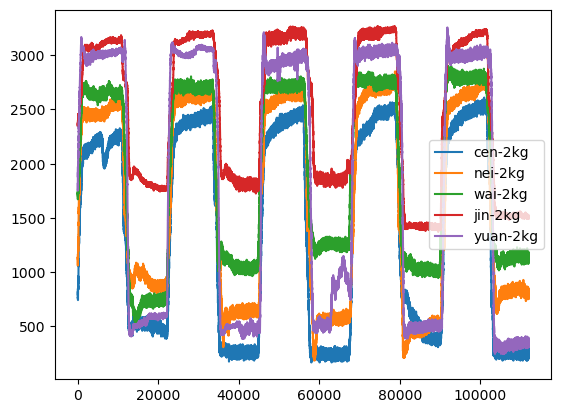

nei-2kg     0.978896
wai-2kg     0.964957
jin-2kg     0.949138
yuan-2kg    0.957142
Name: cen-2kg, dtype: float64


In [33]:
# 选择2kg组，计算各列数据的相关系数
columns_of_interest = ['cen-2kg', 'nei-2kg', 'wai-2kg','jin-2kg', 'yuan-2kg']

# 数据画图
final_df[columns_of_interest].plot()
plt.show()

# 计算相关系数矩阵
correlation_matrix = final_df[columns_of_interest].corr()

# 获取各列与目标列的相关性
target_correlations = correlation_matrix['cen-2kg'].drop('cen-2kg')
print(target_correlations)

In [38]:
# 排除初始压力基线的影响，

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 创建归一化器对象
scaler = StandardScaler()

# 归一化并创建新DataFrame
final_df_normalized = pd.DataFrame(scaler.fit_transform(final_df[file_name_lst]),
                                   columns=file_name_lst,
                                   index=final_df.index)

# 如果需要保留非数值列
# df_normalized = df.copy()
# df_normalized[numeric_cols] = scaler.fit_transform(df[numeric_cols])

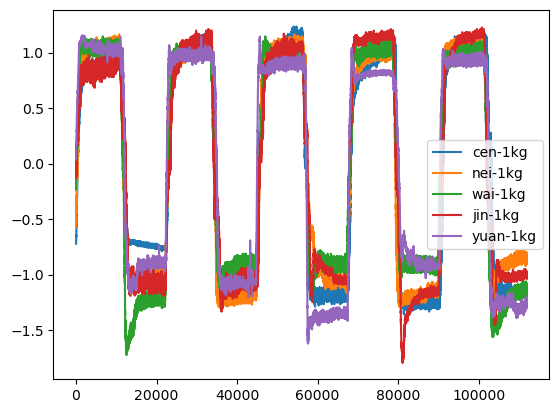

nei-1kg     0.969708
wai-1kg     0.949001
jin-1kg     0.973719
yuan-1kg    0.951592
Name: cen-1kg, dtype: float64


In [39]:
# 选择1kg组，计算各列数据的相关系数
columns_of_interest = ['cen-1kg', 'nei-1kg', 'wai-1kg','jin-1kg', 'yuan-1kg']

final_df_normalized[columns_of_interest].plot()
plt.show()

# 计算相关系数矩阵
correlation_matrix = final_df_normalized[columns_of_interest].corr()

# 获取各列与目标列的相关性
target_correlations = correlation_matrix['cen-1kg'].drop('cen-1kg')
print(target_correlations)

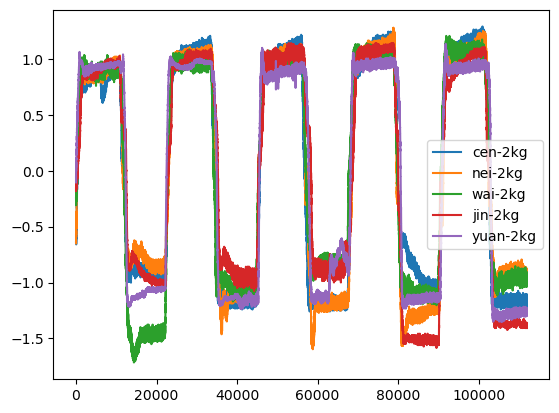

nei-2kg     0.978896
wai-2kg     0.964957
jin-2kg     0.949138
yuan-2kg    0.957142
Name: cen-2kg, dtype: float64


In [40]:
# 选择1kg组，计算各列数据的相关系数
columns_of_interest = ['cen-2kg', 'nei-2kg', 'wai-2kg','jin-2kg', 'yuan-2kg']

final_df_normalized[columns_of_interest].plot()
plt.show()

# 计算相关系数矩阵
correlation_matrix = final_df_normalized[columns_of_interest].corr()

# 获取各列与目标列的相关性
target_correlations = correlation_matrix['cen-2kg'].drop('cen-2kg')
print(target_correlations)